In [1]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

### 1. Make some pose detections (Test if Everything works correctly)

In [2]:
cap = cv2.VideoCapture("Virabhadrasana ii -2.mp4")

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()
        image = cv2.flip(image, 1)

        if not ret:
            break

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)

        # Recolor image from BGR to RGB for mediapipe
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # frame_count = 0  #
        # if frame_count > 20:  # show only first 20 frames  #
        #     break  #
        
        cv2.imshow("CV2", image)

        # Press Q to close cv2 window
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    for i in range (1, 5):
        cv2.waitKey(1)

### 2. Build dataset from collected videos and picture from Kaggle to .csv file for dataset

In [3]:
import csv
import os

#### 2.1 Determine important keypoints and set up important functions


- Correct: "C"

**Important Landmarks**
- 0 nose
- 2 left eye
- 5 right eye
- 11 left shoulder
- 12 right shoulder 
- 13 left elbow
- 14 right elbow
- 19 left index
- 20 right index
- 23 left hip
- 24 right hip
- 25 left knee
- 26 right knee
- 29 left heel
- 30 right heel
- 31 left foot index
- 32 right foot index


In [4]:
# Determine important landmarks for plank
IMPORTANT_LMS = [
    "NOSE",             # 0
    "LEFT_EYE",         # 2
    "RIGHT_EYE",        # 5
    "LEFT_SHOULDER",    # 11
    "RIGHT_SHOULDER",   # 12
    "LEFT_ELBOW",       # 13
    "RIGHT_ELBOW",      # 14
    "LEFT_INDEX",       # 19
    "RIGHT_INDEX",      # 20
    "LEFT_HIP",         # 23
    "RIGHT_HIP",        # 24
    "LEFT_KNEE",        # 25
    "RIGHT_KNEE",       # 26
    "LEFT_HEEL",        # 29
    "RIGHT_HEEL",       # 30
    "LEFT_FOOT_INDEX",  # 31
    "RIGHT_FOOT_INDEX"  # 32
]


# Generate all columns of the data frame

HEADERS = ["label"] # Label column

for lm in IMPORTANT_LMS:
    HEADERS += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

In [48]:
def filter_important_landmarks(input_csv, important_landmarks=IMPORTANT_LMS):
# def filter_important_landmarks(input_csv, output_csv, important_landmarks=IMPORTANT_LMS):
    """
    Filter CSV to keep only important landmarks
    
    Args:
        input_csv: Path to full CSV with all 33 landmarks
        # output_csv: Path to save filtered CSV
        important_landmarks: List of landmark names (uppercase) to keep
    """
    print(f"📊 Filtering landmarks from {input_csv}...")
    
    # Read the full CSV
    df = pd.read_csv(input_csv)
    output_csv = f'main_{input_csv}'
    
    # Convert landmark names to lowercase for matching
    important_lms_lower = [lm.lower() for lm in important_landmarks]
    
    # Columns to keep: label + selected landmarks with x, y, z, visibility
    columns_to_keep = ['label']
    
    for landmark in important_lms_lower:
        columns_to_keep.extend([
            f'{landmark}_x',
            f'{landmark}_y',
            f'{landmark}_z',
            f'{landmark}_visibility'
        ])
    
    # Check if all columns exist
    missing_cols = [col for col in columns_to_keep if col not in df.columns]
    if missing_cols:
        print(f"⚠️  Warning: Missing columns: {missing_cols}")
        # Keep only existing columns
        columns_to_keep = [col for col in columns_to_keep if col in df.columns]
    
    # Filter the dataframe
    df_filtered = df[columns_to_keep]
    
    # Save to new CSV
    df_filtered.to_csv(output_csv, index=False)
    
    print(f"✅ Filtered CSV saved to {output_csv}")
    print(f"   Original: {len(df.columns)} columns → Filtered: {len(df_filtered.columns)} columns")
    print(f"   Kept {len(important_landmarks)} landmarks × 4 values + 1 label = {len(df_filtered.columns)} total")
    print(f"   Total rows: {len(df_filtered)}")
    
    return df_filtered


cv2.destroyAllWindows()
print("🏁 Data extraction completed!")


🏁 Data extraction completed!


In [60]:
def combine_and_cleanup_csvs(csv1, csv2, delete_originals=True):
# def combine_and_cleanup_csvs(csv1, csv2, output_csv, delete_originals=True):
    """
    Combine two CSV files and optionally delete the originals
    
    Args:
        csv1: Path to first CSV file
        csv2: Path to second CSV file
        output_csv: Path to save combined CSV
        delete_originals: If True, delete the original CSV files after combining
    """
    print(f"🔗 Combining CSV files...")
    print(f"   📄 {csv1}")
    print(f"   📄 {csv2}")

    output_csv = 'train.csv'
    
    # Read both CSVs
    try:
        df1 = pd.read_csv(csv1)
        print(f"   ✓ Loaded {csv1}: {len(df1)} rows, {len(df1.columns)} columns")
    except FileNotFoundError:
        print(f"   ❌ File not found: {csv1}")
        return None
    
    try:
        df2 = pd.read_csv(csv2)
        print(f"   ✓ Loaded {csv2}: {len(df2)} rows, {len(df2.columns)} columns")
    except FileNotFoundError:
        print(f"   ❌ File not found: {csv2}")
        return None
    
    # Check if columns match
    if list(df1.columns) != list(df2.columns):
        print("   ⚠️  Warning: Column names don't match perfectly")
        print(f"      CSV1 columns: {len(df1.columns)}")
        print(f"      CSV2 columns: {len(df2.columns)}")
    
    # Combine the dataframes
    df_combined = pd.concat([df1, df2], ignore_index=True)
    
    # Save combined CSV
    df_combined.to_csv(output_csv, index=False)
    print(f"✅ Combined CSV saved to {output_csv}")
    print(f"   Total rows: {len(df_combined)} ({len(df1)} + {len(df2)})")
    print(f"   Total columns: {len(df_combined.columns)}")
    
    # Delete original files if requested
    if delete_originals:
        try:
            os.remove(csv1)
            print(f"🗑️  Deleted: {csv1}")
        except Exception as e:
            print(f"   ⚠️  Could not delete {csv1}: {e}")
        
        try:
            os.remove(csv2)
            print(f"🗑️  Deleted: {csv2}")
        except Exception as e:
            print(f"   ⚠️  Could not delete {csv2}: {e}")
    
    return df_combined

*Set up important functions*

In [ ]:
def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    
# def init_csv(dataset_path: str):
#     '''
#     Create a blank csv file with just columns
#     '''

#     # Ignore if file is already exist
#     if os.path.exists(dataset_path):
#         return

#     # Write all the columns to a empaty file
#     with open(dataset_path, mode="w", newline="") as f:
#         csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
#         csv_writer.writerow(HEADERS)


def init_csv(csv_path):
    """Initialize CSV with proper headers for 33 landmarks (x, y, z, visibility)"""
    if os.path.exists(csv_path):
        print(f"📄 CSV already exists: {csv_path}")
        return
    
    # MediaPipe Pose landmark names (33 total)
    landmark_names = [
        'nose', 'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky', 'right_pinky',
        'left_index', 'right_index',
        'left_thumb', 'right_thumb',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index'
    ]
    
    # Create header: label + landmark names with x, y, z, visibility
    headers = ['label']
    for name in landmark_names:
        headers.extend([
            f'{name}_x',
            f'{name}_y',
            f'{name}_z',
            f'{name}_visibility'
        ])
    
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
    
    print(f"✅ Initialized CSV with {len(headers)} columns (1 label + 33 landmarks × 4 values)")




# def export_landmark_to_csv(csv_path, results, label):
#     """Extract pose landmarks and save to CSV."""
#     if not results.pose_landmarks:
#         return
    
#     landmarks = results.pose_landmarks.landmark
#     row = [label]

#     try:
#         for lm in landmarks:
#             row += [lm.x, lm.y, lm.z, lm.visibility]

#         with open(csv_path, mode='a', newline='') as f:
#             csv.writer(f).writerow(row)
        

#     except Exception as e:
#         print(e)
#         pass


def export_landmark_to_csv(csv_path, results, label):
    """Export all 33 landmarks with x, y, z, visibility to CSV"""
    row = [label]
    
    # Extract all 33 landmarks
    for landmark in results.pose_landmarks.landmark:
        row.extend([
            landmark.x,
            landmark.y,
            landmark.z,
            landmark.visibility
        ])
    
    # Append to CSV
    with open(csv_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(row)
        

# def export_landmark_to_csv(dataset_path: str, results, action: str) -> None:
#     '''
#     Export Labeled Data from detected landmark to csv
#     '''
#     landmarks = results.pose_landmarks.landmark
#     keypoints = []

#     try:
#         # Extract coordinate of important landmarks
#         for lm in IMPORTANT_LMS:
#             keypoint = landmarks[mp_pose.PoseLandmark[lm].value]
#             keypoints.append([keypoint.x, keypoint.y, keypoint.z, keypoint.visibility])
        
#         keypoints = list(np.array(keypoints).flatten())

#         # Insert action as the label (first column)
#         keypoints.insert(0, action)

#         # Append new row to .csv file
#         with open(dataset_path, mode="a", newline="") as f:
#             csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
#             csv_writer.writerow(keypoints)
        

#     except Exception as e:
#         print(e)
#         pass


def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    # duplicate = data[data.duplicated()]
    # print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    print(f"Duplicate Rows : {data.duplicated().sum()}")

    return data


# def remove_duplicate_rows(dataset_path: str):
#     '''
#     Remove duplicated data from the dataset then save it to another files
#     '''
    
#     df = pd.read_csv(dataset_path)
#     df.drop_duplicates(keep="first", inplace=True)
#     df.to_csv(f"cleaned_train.csv", sep=',', encoding='utf-8', index=False)

def remove_duplicate_rows(dataset_path: str, out_path: str = None, subset: list = None, keep: str = "first"):
    """
    Remove duplicated data from the dataset then save it to another file.
    Returns the cleaned DataFrame.
    """
    import os
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"{dataset_path} not found")

    # Explicitly specify that the first row is the header
    df = pd.read_csv(dataset_path, header=0)
    
    before = len(df)
    df_clean = df.drop_duplicates(subset=subset, keep=keep)
    removed = before - len(df_clean)

    if out_path is None:
        out_path = f"cleaned_{os.path.basename(dataset_path)}"

    # Use quoting to handle special characters in data
    df_clean.to_csv(out_path, sep=",", encoding="utf-8", index=False, quoting=1)
    print(f"Removed {removed} duplicate rows — saved to '{out_path}'")
    return df_clean

# def remove_duplicate_rows(dataset_path: str, out_path: str = None, subset: list = None, keep: str = "first"):
#     """
#     Remove duplicated data from the dataset then save it to another file.
#     Returns the cleaned DataFrame.
#     """
#     import os
#     if not os.path.exists(dataset_path):
#         raise FileNotFoundError(f"{dataset_path} not found")

#     df = pd.read_csv(dataset_path)
#     before = len(df)
#     df_clean = df.drop_duplicates(subset=subset, keep=keep)
#     removed = before - len(df_clean)

#     if out_path is None:
#         out_path = f"cleaned_{os.path.basename(dataset_path)}"

#     df_clean.to_csv(out_path, sep=",", encoding="utf-8", index=False)
#     print(f"Removed {removed} duplicate rows — saved to '{out_path}'")
#     return df_clean
    

def concat_csv_files_with_same_headers(file_paths: list, saved_path: str):
    '''
    Concat different csv files
    '''
    all_df = []
    for path in file_paths:
        df = pd.read_csv(path, index_col=None, header=0)
        all_df.append(df)
    
    results = pd.concat(all_df, axis=0, ignore_index=True)
    results.to_csv(saved_path, sep=',', encoding='utf-8', index=False)


# Extract lable from video path
def get_label_from_path_fixed(video_path):
    """Return proper label based on folder name."""
    parts = os.path.normpath(video_path).split(os.sep)
    # For example: warrior-ii_model\warrior-ii_data\Correct\Videos\example.mp4
    if len(parts) >= 3:
        label_folder = parts[-3].lower()  # "Correct"
        if label_folder == "correct":
            return "c"
        else:
            return label_folder[0].lower()
    return "u"

#### 2.2 Extract from video


In [52]:
DATASET_PATH = "train_video.csv"
VIDEO_ROOT = r"D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Videos"

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils


# === Initialize CSV file (if not exists) ===
init_csv(DATASET_PATH)


with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    for root, dirs, files in os.walk(VIDEO_ROOT):
        print("Processing directory:", root)
        for file in files:
            if not file.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
                continue

            video_path = os.path.join(root, file)
            label = get_label_from_path_fixed(video_path)
            print(f"🎥 Processing: {video_path} → Label: {label}")

            cap = cv2.VideoCapture(video_path)
            frame_count = 0
            frames_with_landmarks = 0

            while cap.isOpened():
                ret, image = cap.read()
                if not ret:
                    break

                frame_count += 1
                if frame_count % 4 != 0:
                    continue  # Process every 4th frame

                # Resize + Flip
                image = rescale_frame(image, 60)
                image = cv2.flip(image, 1)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                results = pose.process(image_rgb)

                if results.pose_landmarks:
                    export_landmark_to_csv(DATASET_PATH, results, label)
                    frames_with_landmarks += 1

            cap.release()
            print(f"✅ {file} → Saved {frames_with_landmarks} frames with landmarks")

cv2.destroyAllWindows()
print("🏁 Data extraction completed!")

✅ Initialized CSV with 133 columns (1 label + 33 landmarks × 4 values)
Processing directory: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Videos
🎥 Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Videos\Virabhadrasana ii -2.mp4 → Label: c
✅ Virabhadrasana ii -2.mp4 → Saved 61 frames with landmarks
🎥 Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Videos\Virabhadrasana ii -3.mp4 → Label: c
✅ Virabhadrasana ii -3.mp4 → Saved 60 frames with landmarks
🎥 Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Videos\Virabhadrasana ii.mp4 → Label: c
✅ Virabhadrasana ii.mp4 → Saved 72 frames with landmarks
🏁 Data extraction completed!


In [36]:
# DATASET_PATH = "train.csv"
# VIDEO_ROOT = r"D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Videos"


# mp_pose = mp.solutions.pose
# mp_drawing = mp.solutions.drawing_utils


# # === Initialize CSV file (if not exists) ===
# init_csv(DATASET_PATH)


# # === Extract Landmarks from Videos ===
# with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
#     for root, dirs, files in os.walk(VIDEO_ROOT):
#         print("Here!!")
#         for file in files:
#             if not file.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
#                 continue

#             video_path = os.path.join(root, file)
#             label = get_label_from_path_fixed(video_path)
#             print(f"🎥 Processing: {video_path} → Label: {label}")

#             cap = cv2.VideoCapture(video_path)
#             frame_count = 0
#             frames_with_landmarks = 0

#             while cap.isOpened():
#                 ret, image = cap.read()
#                 if not ret:
#                     break

#                 frame_count += 1
#                 if frame_count % 4 != 0:
#                     continue  # Skip 3 frames, process every 4th

#                 # Resize + Flip
#                 image = rescale_frame(image, 60)
#                 image = cv2.flip(image, 1)
#                 image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#                 results = pose.process(image_rgb)

#                 if results.pose_landmarks:
#                     export_landmark_to_csv(DATASET_PATH, results, label)
#                     frames_with_landmarks += 1

#             cap.release()
#             print(f"✅ {file} → Saved {frames_with_landmarks} frames with landmarks")

# cv2.destroyAllWindows()
# print("🏁 Data extraction completed from Correct\\Videos!")

Here!!
🎥 Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Videos\Virabhadrasana ii -2.mp4 → Label: c
✅ Virabhadrasana ii -2.mp4 → Saved 61 frames with landmarks
🎥 Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Videos\Virabhadrasana ii -3.mp4 → Label: c
✅ Virabhadrasana ii -3.mp4 → Saved 60 frames with landmarks
🎥 Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Videos\Virabhadrasana ii.mp4 → Label: c
✅ Virabhadrasana ii.mp4 → Saved 72 frames with landmarks
🏁 Data extraction completed from Correct\Videos!


In [ ]:
# DATASET_PATH = "train.csv"

# # cap = cv2.VideoCapture("../data/plank/bad/plank_bad_high_4.mp4")
# cap = cv2.VideoCapture("Virabhadrasana ii -2.mp4")

# save_counts = 0

# # init_csv(DATASET_PATH)

# with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
#     while cap.isOpened():
#         ret, image = cap.read()

#         if not ret:
#             break

#         # Reduce size of a frame
#         image = rescale_frame(image, 60)
#         image = cv2.flip(image, 1)

#         # Recolor image from BGR to RGB for mediapipe
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image.flags.writeable = False

#         results = pose.process(image)

#         if not results.pose_landmarks: continue

#         # Recolor image from BGR to RGB for mediapipe
#         image.flags.writeable = True
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

#         # Draw landmarks and connections
#         mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

#         # Display the saved count
#         cv2.putText(image, f"Saved: {save_counts}", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)

#         cv2.imshow("CV2", image)

#         # Pressed key for action
#         k = cv2.waitKey(1) & 0xFF

#         # Press C to save as correct form
#         if k == ord('c'): 
#             export_landmark_to_csv(DATASET_PATH, results, "C")
#             save_counts += 1
#         # Press L to save as low back
#         elif k == ord("l"):
#             export_landmark_to_csv(DATASET_PATH, results, "L")
#             save_counts += 1
#         # Press L to save as high back
#         elif k == ord("h"):
#             export_landmark_to_csv(DATASET_PATH, results, "H")
#             save_counts += 1

#         # Press q to stop
#         elif k == ord("q"):
#             break
#         else: continue

#     cap.release()
#     cv2.destroyAllWindows()

#     for i in range (1, 5):
#         cv2.waitKey(1)
        

In [54]:
# csv_files = [os.path.join("./", f) for f in os.listdir("./") if "csv" in f]

# concat_csv_files_with_same_headers(csv_files, "train.csv")

DATASET_PATH = "train_video.csv"

remove_duplicate_rows(DATASET_PATH)
df = describe_dataset(DATASET_PATH)


Removed 0 duplicate rows — saved to 'cleaned_train_video.csv'
Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_visibility', 'left_eye_inner_x', 'left_eye_inner_y', 'left_eye_inner_z', 'left_eye_inner_visibility', 'left_eye_x', 'left_eye_y', 'left_eye_z', 'left_eye_visibility', 'left_eye_outer_x', 'left_eye_outer_y', 'left_eye_outer_z', 'left_eye_outer_visibility', 'right_eye_inner_x', 'right_eye_inner_y', 'right_eye_inner_z', 'right_eye_inner_visibility', 'right_eye_x', 'right_eye_y', 'right_eye_z', 'right_eye_visibility', 'right_eye_outer_x', 'right_eye_outer_y', 'right_eye_outer_z', 'right_eye_outer_visibility', 'left_ear_x', 'left_ear_y', 'left_ear_z', 'left_ear_visibility', 'right_ear_x', 'right_ear_y', 'right_ear_z', 'right_ear_visibility', 'mouth_left_x', 'mouth_left_y', 'mouth_left_z', 'mouth_left_visibility', 'mouth_right_x', 'mouth_right_y', 'mouth_right_z', 'mouth_right_visibility', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_visibility', 'ri

In [58]:
DATASET_PATH = "cleaned_train_video.csv"

filter_important_landmarks(DATASET_PATH)

📊 Filtering landmarks from cleaned_train_video.csv...
✅ Filtered CSV saved to main_cleaned_train_video.csv
   Original: 133 columns → Filtered: 69 columns
   Kept 17 landmarks × 4 values + 1 label = 69 total
   Total rows: 193


,label,nose_x,nose_y,nose_z,nose_visibility,left_eye_x,left_eye_y,left_eye_z,left_eye_visibility,right_eye_x,...,right_heel_z,right_heel_visibility,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_visibility,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_visibility
0,c,0.545102,0.260763,-0.205517,0.999987,0.543061,0.242668,-0.179576,0.999966,0.536352,...,0.007846,0.901300,0.702652,0.988751,-0.156927,0.985408,0.312762,0.990084,-0.113388,0.983387
1,c,0.545697,0.260760,-0.204575,0.999986,0.543025,0.242556,-0.180319,0.999966,0.536528,...,0.001757,0.906264,0.702661,0.987784,-0.159373,0.986124,0.314311,0.990002,-0.112362,0.983611
2,c,0.546162,0.260788,-0.210042,0.999987,0.542996,0.242419,-0.190575,0.999966,0.536795,...,-0.005847,0.911553,0.702525,0.987360,-0.157785,0.986840,0.314763,0.988987,-0.114114,0.983976
3,c,0.546332,0.261146,-0.203094,0.999987,0.542803,0.242452,-0.186558,0.999966,0.536911,...,-0.007881,0.916150,0.702599,0.987358,-0.157843,0.987430,0.315108,0.988174,-0.115528,0.984215
4,c,0.546414,0.261260,-0.187810,0.999986,0.542535,0.242451,-0.170970,0.999964,0.536934,...,-0.005755,0.920102,0.702875,0.987377,-0.153618,0.987815,0.315263,0.987887,-0.112874,0.984232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,c,0.484867,0.196868,-0.288399,0.999981,0.493049,0.181473,-0.265030,0.999953,0.476634,...,0.008753,0.932161,0.650193,0.942790,-0.074935,0.983184,0.294728,0.956957,-0.110885,0.984616
189,c,0.485810,0.197600,-0.288298,0.999981,0.494151,0.182523,-0.264900,0.999954,0.477709,...,0.006579,0.931756,0.651893,0.942681,-0.075691,0.983014,0.294804,0.956909,-0.112689,0.984393
190,c,0.487971,0.200894,-0.288374,0.999982,0.496268,0.184982,-0.264922,0.999956,0.479857,...,0.000138,0.931417,0.653101,0.942697,-0.085998,0.983014,0.294854,0.956814,-0.117507,0.984226
191,c,0.503386,0.215423,-0.288377,0.999982,0.507358,0.198038,-0.264702,0.999955,0.493060,...,-0.015261,0.930896,0.653573,0.942802,-0.091139,0.983133,0.294943,0.956735,-0.127919,0.984120


<Axes: xlabel='label', ylabel='count'>

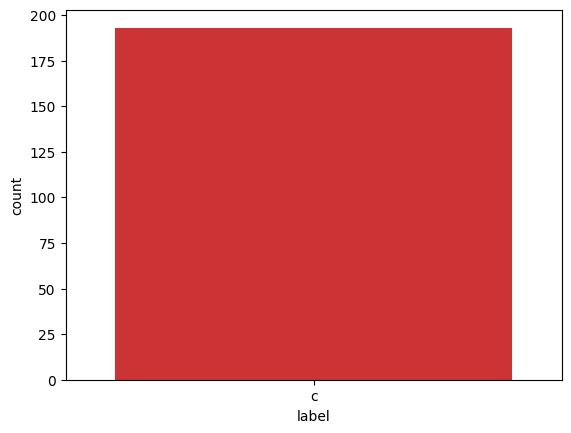

In [40]:
sns.countplot(x='label', data=df, palette="Set1") 


#### 2.3. Extract from Kaggle dataset (Photos)

In [55]:
DATASET_PATH = "train_photos.csv"
PHOTO_ROOT = r"D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images"

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# === Initialize CSV file ===
init_csv(DATASET_PATH)

# === Extract Landmarks from Photos ===
with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
    total_images = 0
    images_with_landmarks = 0

    for root, dirs, files in os.walk(PHOTO_ROOT):
        for file in files:
            if not file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
                continue

            total_images += 1
            image_path = os.path.join(root, file)
            label = get_label_from_path_fixed(image_path)

            print(f"🖼️ Processing: {image_path} → Label: {label}")

            image = cv2.imread(image_path)
            if image is None:
                print(f"⚠️ Could not read image: {file}")
                continue

            image = rescale_frame(image, 60)
            image = cv2.flip(image, 1)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            results = pose.process(image_rgb)

            if results.pose_landmarks:
                export_landmark_to_csv(DATASET_PATH, results, label)
                images_with_landmarks += 1
            else:
                print(f"🚫 No pose detected in: {file}")

print(f"🏁 Data extraction completed from photos!")
print(f"✅ Total processed: {total_images} | Saved with landmarks: {images_with_landmarks}")

✅ Initialized CSV with 133 columns (1 label + 33 landmarks × 4 values)
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File1.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File11.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File12.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File13.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File14.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File15.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File16.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File17.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File18.png → Label: c
🖼️ Processin

In [21]:
# DATASET_PATH = "train_photos.csv"
# PHOTO_ROOT = r"D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images"

# mp_pose = mp.solutions.pose
# mp_drawing = mp.solutions.drawing_utils

# # === Initialize CSV file ===
# init_csv(DATASET_PATH)

# # === Extract Landmarks from Photos ===
# with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
#     total_images = 0
#     images_with_landmarks = 0

#     for root, dirs, files in os.walk(PHOTO_ROOT):
#         for file in files:
#             if not file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
#                 continue

#             total_images += 1
#             image_path = os.path.join(root, file)
#             label = get_label_from_path_fixed(image_path)

#             print(f"🖼️ Processing: {image_path} → Label: {label}")

#             image = cv2.imread(image_path)
#             if image is None:
#                 print(f"⚠️ Could not read image: {file}")
#                 continue

#             image = rescale_frame(image, 60)
#             image = cv2.flip(image, 1)
#             image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#             results = pose.process(image_rgb)

#             if results.pose_landmarks:
#                 export_landmark_to_csv(DATASET_PATH, results, label)
#                 images_with_landmarks += 1
#             else:
#                 print(f"🚫 No pose detected in: {file}")

# print(f"🏁 Data extraction completed from photos!")
# print(f"✅ Total processed: {total_images} | Saved with landmarks: {images_with_landmarks}")

🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File1.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File11.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File12.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File13.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File14.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File15.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File16.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File17.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\File18.png → Label: c
🖼️ Processing: D:\Project_model\warrior-ii_model\warrior-ii_data\Correct\Images\Fil

In [56]:
DATASET_PATH = "train_photos.csv"
remove_duplicate_rows(DATASET_PATH)
df = describe_dataset(DATASET_PATH)

Removed 0 duplicate rows — saved to 'cleaned_train_photos.csv'
Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_visibility', 'left_eye_inner_x', 'left_eye_inner_y', 'left_eye_inner_z', 'left_eye_inner_visibility', 'left_eye_x', 'left_eye_y', 'left_eye_z', 'left_eye_visibility', 'left_eye_outer_x', 'left_eye_outer_y', 'left_eye_outer_z', 'left_eye_outer_visibility', 'right_eye_inner_x', 'right_eye_inner_y', 'right_eye_inner_z', 'right_eye_inner_visibility', 'right_eye_x', 'right_eye_y', 'right_eye_z', 'right_eye_visibility', 'right_eye_outer_x', 'right_eye_outer_y', 'right_eye_outer_z', 'right_eye_outer_visibility', 'left_ear_x', 'left_ear_y', 'left_ear_z', 'left_ear_visibility', 'right_ear_x', 'right_ear_y', 'right_ear_z', 'right_ear_visibility', 'mouth_left_x', 'mouth_left_y', 'mouth_left_z', 'mouth_left_visibility', 'mouth_right_x', 'mouth_right_y', 'mouth_right_z', 'mouth_right_visibility', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_visibility', 'r

In [57]:
DATASET_PATH = "cleaned_train_photos.csv"

filter_important_landmarks(DATASET_PATH)

📊 Filtering landmarks from cleaned_train_photos.csv...
✅ Filtered CSV saved to main_cleaned_train_photos.csv
   Original: 133 columns → Filtered: 69 columns
   Kept 17 landmarks × 4 values + 1 label = 69 total
   Total rows: 227


,label,nose_x,nose_y,nose_z,nose_visibility,left_eye_x,left_eye_y,left_eye_z,left_eye_visibility,right_eye_x,...,right_heel_z,right_heel_visibility,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_visibility,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_visibility
0,c,0.437655,0.152508,-0.402598,0.999969,0.454337,0.129483,-0.405469,0.999809,0.432479,...,0.088568,0.978687,0.945377,0.987349,-0.286707,0.967234,0.163435,0.981361,-0.021600,0.939426
1,c,0.409280,0.077575,0.001537,0.999762,0.419597,0.056919,-0.058471,0.999930,0.429959,...,0.623533,0.965287,0.081298,0.933119,0.316853,0.982421,0.903984,0.906124,0.647173,0.960393
2,c,0.372050,0.094486,-0.336091,0.999709,0.392808,0.075286,-0.351443,0.999138,0.380203,...,0.040163,0.985895,0.934063,0.963967,-0.308571,0.974629,0.018908,0.943668,-0.095796,0.959317
3,c,0.561121,0.122888,-0.325309,0.999983,0.553312,0.097480,-0.280922,0.999968,0.542735,...,-0.126329,0.980602,0.854289,0.945201,-0.188232,0.990712,-0.008046,0.940864,-0.320645,0.996025
4,c,0.419632,0.119746,-0.250630,0.999963,0.438144,0.097548,-0.260617,0.999873,0.427426,...,-0.011132,0.989075,0.919005,0.955434,-0.032544,0.979808,0.087362,0.964989,-0.176535,0.988433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,c,0.523859,0.196117,0.041704,0.999889,0.510612,0.176065,0.032132,0.999934,0.513478,...,0.160503,0.992562,0.211338,0.898953,0.136536,0.984762,0.710380,0.897877,0.165587,0.985728
223,c,0.410330,0.194136,-0.220154,0.999953,0.429313,0.174971,-0.216794,0.999850,0.415162,...,-0.044094,0.988298,0.803608,0.934920,-0.123308,0.985117,0.210947,0.926621,-0.155718,0.985446
224,c,0.424106,0.146213,-0.247363,0.999939,0.438804,0.126335,-0.250451,0.999722,0.428857,...,0.053672,0.981947,0.817760,0.971051,-0.216408,0.972980,0.129584,0.945373,-0.066014,0.977821
225,c,0.477496,0.148614,0.020281,0.999769,0.465529,0.129889,-0.040604,0.999847,0.494884,...,0.173060,0.990349,0.044100,0.938926,0.191288,0.967012,0.814445,0.902226,0.151622,0.972173


In [ ]:
# # FOLDER_PATH = "../data/kaggle/TRAIN/plank"
# FOLDER_PATH = "Plank_Correct"
# picture_files = [os.path.join(FOLDER_PATH, f) for f in os.listdir(FOLDER_PATH) if os.path.isfile(os.path.join(FOLDER_PATH, f))]
# print(f"Total pictures: {len(picture_files)}")

# DATASET_PATH = "./kaggle.csv"
# saved_counts = 0

# init_csv(DATASET_PATH)

# with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:
#     index = 0
    
#     while True:
#         if index == len(picture_files):
#             break
        
#         file_path = picture_files[index]

#         image = cv2.imread(file_path)

#         # Flip image horizontally for more data
#         image = cv2.flip(image, 1)

#         # get dimensions of image
#         dimensions = image.shape
        
#         # height, width, number of channels in image
#         height = image.shape[0]
#         width = image.shape[1]
#         channels = image.shape[2]

#         # Reduce size of a frame
#         if width > 1000:
#             image = rescale_frame(image, 60)

#         # Recolor image from BGR to RGB for mediapipe
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image.flags.writeable = False

#         results = pose.process(image)

#         # Recolor image from BGR to RGB for mediapipe
#         image.flags.writeable = True
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

#         # Draw landmarks and connections
#         mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

#         # Display the saved count
#         cv2.putText(image, f"Saved: {saved_counts}", (20, 20), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)
        
#         cv2.imshow("CV2", image)

#         k = cv2.waitKey(1) & 0xFF

#         # Press D to skip this image (If user pressed "d", advance the index (move to the next image/frame))
#         if k == ord('d'): 
#             index += 1

#         # If user pressed "s", save current pose landmarks to DATASET_PATH with label "C" and increment saved_counts
#         elif k == ord("s"):
#             export_landmark_to_csv(DATASET_PATH, results, "C")
#             saved_counts += 1

#         # If user pressed "f", advance the index and delete the current file (file_path) from disk.
#         elif k == ord("f"):
#             index += 1
#             os.remove(file_path)

#         # If user pressed "q", exit the loop (stop processing)
#         elif k == ord("q"):
#             break

#         else:
#             continue

#         # # Press Q to close cv2 window
#         # if cv2.waitKey(1) & 0xFF == ord('d'):
#         #     index += 1

#         # # Press Q to close cv2 window
#         # if cv2.waitKey(1) & 0xFF == ord('q'):
#         #     break

#     # Close cv2 window
#     cv2.destroyAllWindows()

#     for i in range (1, 5):
#         cv2.waitKey(1)

### 3. Refine Data & Data Visualization

<Axes: xlabel='label', ylabel='count'>

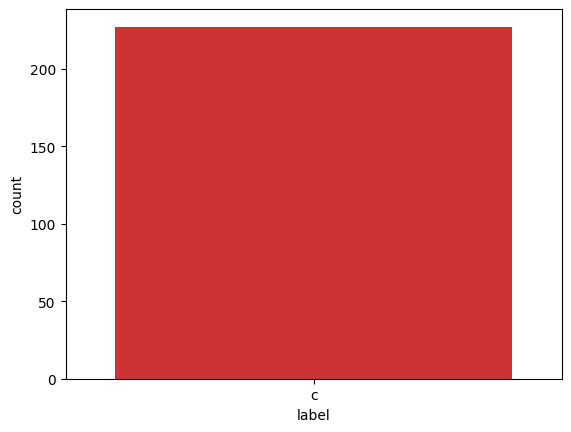

In [43]:
sns.countplot(x='label', data=df, palette="Set1") 

In [61]:
combine_and_cleanup_csvs("main_cleaned_train_video.csv", "main_cleaned_train_photos.csv")

🔗 Combining CSV files...
   📄 main_cleaned_train_video.csv
   📄 main_cleaned_train_photos.csv
   ✓ Loaded main_cleaned_train_video.csv: 193 rows, 69 columns
   ✓ Loaded main_cleaned_train_photos.csv: 227 rows, 69 columns
✅ Combined CSV saved to train.csv
   Total rows: 420 (193 + 227)
   Total columns: 69
🗑️  Deleted: main_cleaned_train_video.csv
🗑️  Deleted: main_cleaned_train_photos.csv


,label,nose_x,nose_y,nose_z,nose_visibility,left_eye_x,left_eye_y,left_eye_z,left_eye_visibility,right_eye_x,...,right_heel_z,right_heel_visibility,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_visibility,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_visibility
0,c,0.545102,0.260763,-0.205517,0.999987,0.543061,0.242668,-0.179576,0.999966,0.536352,...,0.007846,0.901300,0.702652,0.988751,-0.156927,0.985408,0.312762,0.990084,-0.113388,0.983387
1,c,0.545697,0.260760,-0.204575,0.999986,0.543025,0.242556,-0.180319,0.999966,0.536528,...,0.001757,0.906264,0.702661,0.987784,-0.159373,0.986124,0.314311,0.990002,-0.112362,0.983611
2,c,0.546162,0.260788,-0.210042,0.999987,0.542996,0.242419,-0.190575,0.999966,0.536795,...,-0.005847,0.911553,0.702525,0.987360,-0.157785,0.986840,0.314763,0.988987,-0.114114,0.983976
3,c,0.546332,0.261146,-0.203094,0.999987,0.542803,0.242452,-0.186558,0.999966,0.536911,...,-0.007881,0.916150,0.702599,0.987358,-0.157843,0.987430,0.315108,0.988174,-0.115528,0.984215
4,c,0.546414,0.261260,-0.187810,0.999986,0.542535,0.242451,-0.170970,0.999964,0.536934,...,-0.005755,0.920102,0.702875,0.987377,-0.153618,0.987815,0.315263,0.987887,-0.112874,0.984232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,c,0.523859,0.196117,0.041704,0.999889,0.510612,0.176065,0.032132,0.999934,0.513478,...,0.160503,0.992562,0.211338,0.898953,0.136536,0.984762,0.710380,0.897877,0.165587,0.985728
416,c,0.410330,0.194136,-0.220154,0.999953,0.429313,0.174971,-0.216794,0.999850,0.415162,...,-0.044094,0.988298,0.803608,0.934920,-0.123308,0.985117,0.210947,0.926621,-0.155718,0.985446
417,c,0.424106,0.146213,-0.247363,0.999939,0.438804,0.126335,-0.250451,0.999722,0.428857,...,0.053672,0.981947,0.817760,0.971051,-0.216408,0.972980,0.129584,0.945373,-0.066014,0.977821
418,c,0.477496,0.148614,0.020281,0.999769,0.465529,0.129889,-0.040604,0.999847,0.494884,...,0.173060,0.990349,0.044100,0.938926,0.191288,0.967012,0.814445,0.902226,0.151622,0.972173


### 5. Extract data for test set

In [ ]:
TEST_DATASET_PATH = "test.csv"

cap = cv2.VideoCapture("../data/plank/plank_test_4.mp4")
save_counts = 0

# init_csv(TEST_DATASET_PATH)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        if not ret:
            break

        # Reduce size of a frame
        image = rescale_frame(image, 60)
        image = cv2.flip(image, 1)

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)

        if not results.pose_landmarks: continue

        # Recolor image from BGR to RGB for mediapipe
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Display the saved count
        cv2.putText(image, f"Saved: {save_counts}", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 0), 2, cv2.LINE_AA)

        cv2.imshow("CV2", image)

        # Pressed key for action
        k = cv2.waitKey(1) & 0xFF

        # Press C to save as correct form
        if k == ord('c'): 
            export_landmark_to_csv(TEST_DATASET_PATH, results, "C")
            save_counts += 1
        # Press L to save as low back
        elif k == ord("l"):
            export_landmark_to_csv(TEST_DATASET_PATH, results, "L")
            save_counts += 1
        # Press L to save as high back
        elif k == ord("h"):
            export_landmark_to_csv(TEST_DATASET_PATH, results, "H")
            save_counts += 1

        # Press q to stop
        elif k == ord("q"):
            break
        else: continue

    cap.release()
    cv2.destroyAllWindows()

    for i in range (1, 5):
        cv2.waitKey(1)
        

In [9]:
test_df = describe_dataset(TEST_DATASET_PATH)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'lef

<Axes: xlabel='count', ylabel='label'>

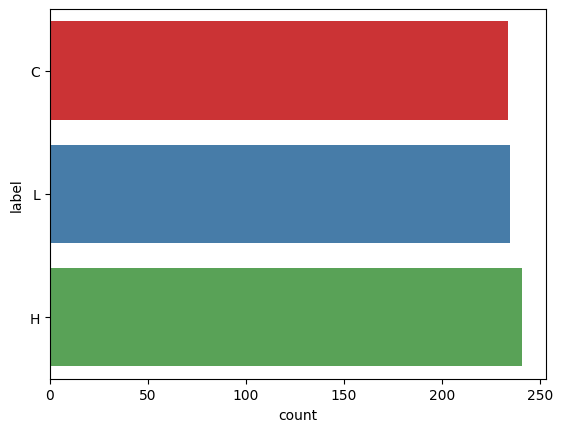

In [10]:
sns.countplot(y='label', data=test_df, palette="Set1") 